In [1]:
from bs4 import BeautifulSoup
import requests
import re
import json
from pprint import pprint
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

## Get review-data from userDk-folder

In [2]:
# Folder containing reviews
reviewsFolder = os.listdir('reviews/Denmark')

# Get usersDk from folder
reviews = {}
for r in reviewsFolder:
    print(r, end="\r")
    f = open('reviews/Denmark/' + r)
    reviews[re.sub(r'.json',"",r)] = json.load(f)

# Get names of businesses
businessNames = list(reviews.keys())

In [3]:
# Folder containing reviews
reviewsFolderExpanded = os.listdir('users/usersDk')

# Get usersDk from folder
reviewsExpanded = {}
for r in reviewsFolderExpanded:
    print(r, end="\r")
    f = open('users/usersDk/' + r)
    reviewsExpanded[re.sub(r'.json',"",r)] = json.load(f)

# Get names of businesses
businessNamesExpanded = list(reviewsExpanded.keys())

## Make network

In [4]:
import networkx as nx

In [5]:
G = nx.Graph()
allBusinesses = []
count = 0
# Add nodes, edges and node_color
for business in businessNamesExpanded:
    count += 1
    # Business nodes
    G.add_node(business, bipartite=0)
    
    # User nodes
    for user in reviewsExpanded[business]:
        userId = list(user.keys())[0]
        
        G.add_node(userId, bipartite=1)
        
        # Edges between users and nodes
        reviewer = user[userId]
        for review in reviewer:
            outNode = review["businessUnitId"]
            allBusinesses.append(outNode)
            if not G.has_node(outNode):
                G.add_node(outNode, bipartite=2)
            G.add_edge(userId, outNode)
    #print(count, ":", len(businessNames), end="\r")

allBusinesses = [*set(allBusinesses)]

In [6]:
print("Number of businesses", len(allBusinesses))

Number of businesses 58546


In [7]:
print("Number of nodes:",len(G.nodes()))
print("Number of edges:",len(G.edges()))

Number of nodes: 150953
Number of edges: 1032772


In [8]:
# Color, size and alpha maps
G_node_color = []
G_node_size = []
G_node_alpha = []

# Sets containing bipartite groups
set0 = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # Set containing all nodes in bipartite group 0.
set1 = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1} # Set containing all nodes in bipartite group 1.
# Everything outside 1 and 2 is considered group 3.

# List of nodes and their degree
node_list = list(G.nodes())
d = nx.degree(G)

# Append color, size and alpha for each node
for i in range(G.number_of_nodes()):
    node_name = node_list[i]
    node_size = d(node_name)*10
    if node_name in set0:
        G_node_color.append("tab:red")
        G_node_size.append(node_size)
        G_node_alpha.append(1)
    elif node_name in set1:
        G_node_color.append("tab:blue")
        G_node_size.append(node_size)
        G_node_alpha.append(0.6)
    else:
        G_node_color.append("tab:green")
        G_node_size.append(node_size)
        G_node_alpha.append(0.3)

In [9]:
# Biggest hubs outside of restaurant and bars
for node in G.nodes():
    if not node in set0 and not node in set1:
        if len(G.edges(node)) > 5000:
            print(node, len(G.edges(node)))

gls-group.eu/dk/da/home 21918
www.bring.dk 18350
www.postnord.dk 34558
coolshop.dk 6077
www.av-cables.dk 6318
dao.as 11128
shopping.coop.dk 7165
www.boozt.com 5077
www.magasin.dk 5199
www.elgiganten.dk 7405


In [10]:
# Time tp draw the network
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

In [11]:
# Set True if you want to draw netowrk. Network is large...
draw_network = False

In [12]:
if draw_network:
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=0.5,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2,
                            strongGravityMode=False,
                            gravity=500,

                            # Log
                            verbose=True)

    plt.figure(figsize=(25, 25))
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)
    nx.draw_networkx_nodes(G, positions, node_size=G_node_size, node_color=G_node_color, alpha=G_node_alpha)
    nx.draw_networkx_edges(G, positions, edge_color="black", alpha=.05)
    plt.axis('off')
    plt.show()

## Communities

In [13]:
import community

In [14]:
# Finding the communities
communities = community.best_partition(G)

In [15]:
# Grouping the communities
G_community = []
n = max(communities.values())

for i in range(n):
    temp_list = []
    for key in list(communities.keys()):
        if i == communities[key]:
            temp_list.append(key)
    G_community.append(temp_list)

In [16]:
# Assigning color to each community
colors = []

for val in list(communities.values()):
    colors.append(val)

In [17]:
# Visualization
if draw_network:
    plt.figure(figsize=(25, 25))
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)
    nx.draw_networkx_nodes(G, positions, node_size=G_node_size, node_color=colors, alpha=G_node_alpha)
    nx.draw_networkx_edges(G, positions, edge_color="black", alpha=0.05)
    plt.axis('off')
    plt.show()

In [18]:
# Find modularity
print("The modularity for the graph is:", round(community.modularity(communities, G),3))

The modularity for the graph is: 0.275


In [19]:
# List of communities and their no. nodes
print("There are", len(G_community), "communities.\n")
counter = 0
for i, community in enumerate(G_community):
    print("Community",i,"contains",len(community),"nodes.")
    counter += len(community)
print("Total nodes in communities:",counter)

There are 90 communities.

Community 0 contains 6659 nodes.
Community 1 contains 31303 nodes.
Community 2 contains 1902 nodes.
Community 3 contains 35287 nodes.
Community 4 contains 10651 nodes.
Community 5 contains 12622 nodes.
Community 6 contains 830 nodes.
Community 7 contains 3089 nodes.
Community 8 contains 16751 nodes.
Community 9 contains 2 nodes.
Community 10 contains 7422 nodes.
Community 11 contains 3530 nodes.
Community 12 contains 4960 nodes.
Community 13 contains 4 nodes.
Community 14 contains 5023 nodes.
Community 15 contains 163 nodes.
Community 16 contains 3 nodes.
Community 17 contains 3 nodes.
Community 18 contains 359 nodes.
Community 19 contains 985 nodes.
Community 20 contains 3 nodes.
Community 21 contains 240 nodes.
Community 22 contains 1 nodes.
Community 23 contains 5 nodes.
Community 24 contains 3218 nodes.
Community 25 contains 61 nodes.
Community 26 contains 2 nodes.
Community 27 contains 203 nodes.
Community 28 contains 24 nodes.
Community 29 contains 3 no

In [20]:
# Sort communities by size (large to small)
G_community.sort(key=len, reverse=True)

In [21]:
# Number of nodes of the ten largest communities
for i in range(10):
    print(i, len(G_community[i]))

0 35287
1 31303
2 16751
3 12622
4 10651
5 7422
6 6659
7 5023
8 4960
9 3530


In [22]:
# Total nodes in ten largest communities
s = 0
for i in range(10):
    s += len(G_community[i])
print(s)

134208


In [23]:
# % of nodes in top ten communities
s/len(G)*100

88.90714328300862

In [24]:
# Find reviews from each user in the community. 
# Only use text from business reviews from the trustpilot category 'Restaurant and Bars', 
# not anything outside of this category.
text = []
for community in G_community[0:10]:
    # Finding userIds
    fnames = [x for x in community if x in set1]
    # Remove empty elements
    while("" in fnames):
        fnames.remove("")
    #print(fnames)
    
    temp_text = ""
    
    for fname in fnames:
        for businessId in list(G.neighbors(fname)):
            if businessId in set0:
                #print(businessId, fname)
                for review in reviewsExpanded[businessId]:
                    if fname in list(review.keys()):
                        for busName in review[fname]: 
                            if busName['businessUnitId'] in set0:
                                temp_text += busName['review']
    text.append(temp_text)

In [25]:
# Text before being processed
print(text[0][0:500])

Deijlige værelser med fælles hyggestue. Det passede godt til os, da vi var 4 par. Super dejligt fiske og skaldyrsbuffet 👏😋 alt var godt. Virkelig dejligt morgenbord med hjemmelavet pålæg m.m.
Venligt personale. Alt i alten dejlig oplevelse 👍
Vi kommet gerne igen for 3. gang.Sød og meget venlig betjening.
Hyggeligt lokale og pæn opdækning på bordene.
Maden levede helt op til forventningerne.
Dog var foiegras stegt for lidt.
Kommer gerne igen.Deijlige værelser med fælles hyggestue. Det passede god


In [26]:
# Process text
for i in range(len(text)):
    # Lower case
    combined_words_str = text[i].lower()

    # Remove all non-alphabetic chars
    combined_words_str = re.sub(r'[^a-zA-ZÆØÅæøå\ ]', '', combined_words_str)

    # Remove excessive spaces
    combined_words_str = re.sub(' +', ' ', combined_words_str)

    # Remove stopwords
    #stop_words = stopwords.words('danish') # Was lacking stop_words
    stop_words = open("stopord.txt", "r", encoding="utf-8").read().split()
    text[i] = ' '.join([word for word in combined_words_str.split() if word not in stop_words])

In [27]:
# Text after being processed
print(text[0][0:500])

deijlige værelser fælles hyggestue passede par super dejligt fiske skaldyrsbuffet virkelig dejligt morgenbord hjemmelavet pålæg mmvenligt personale alten dejlig oplevelse kommet gerne gangsød venlig betjeninghyggeligt lokale pæn opdækning bordenemaden levede forventningernedog foiegras stegt lidtkommer gerne igendeijlige værelser fælles hyggestue passede par super dejligt fiske skaldyrsbuffet virkelig dejligt morgenbord hjemmelavet pålæg mmvenligt personale alten dejlig oplevelse kommet gerne ga


## Wordcloud of communities

In [28]:
# Word Cloud time
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from wordcloud import WordCloud, ImageColorGenerator

In [29]:
# Read mask image
d = os.getcwd()
mask = np.array(Image.open(os.path.join(d, "wordcloud\\mask\\trustpilot_mask_4.jpg")))

In [30]:
# subsampling by factor 3
color = mask[::3, ::3]

In [31]:
# create mask white is "masked out"
mask = color.copy()
mask[mask.sum(axis=2) == 0] = 0

In [32]:
edges = np.mean([gaussian_gradient_magnitude(color[:, :, i] / 255., 2) for i in range(3)], axis=0)
mask[edges > .08] = 0

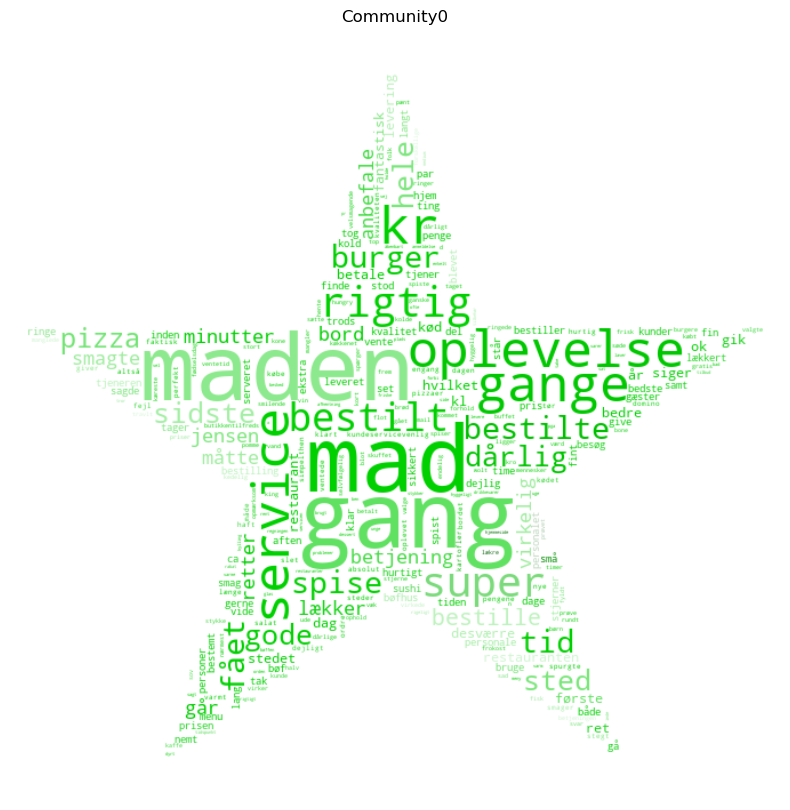

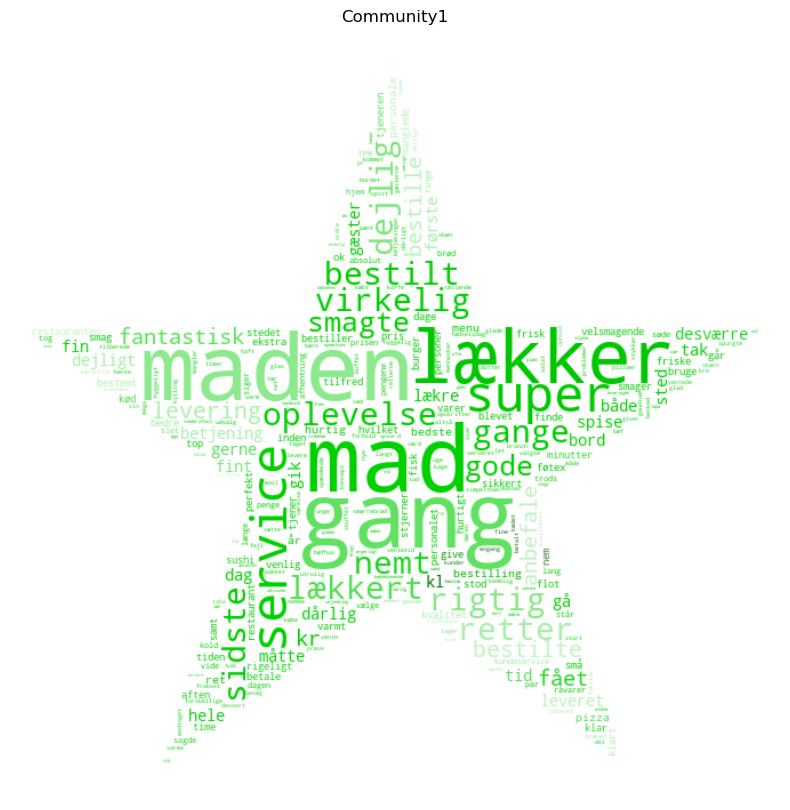

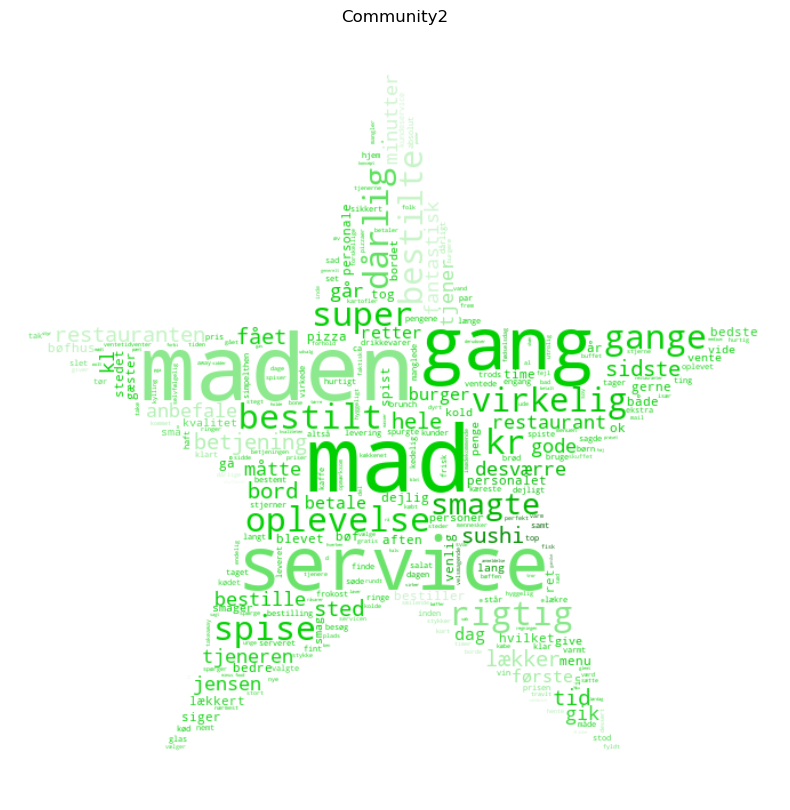

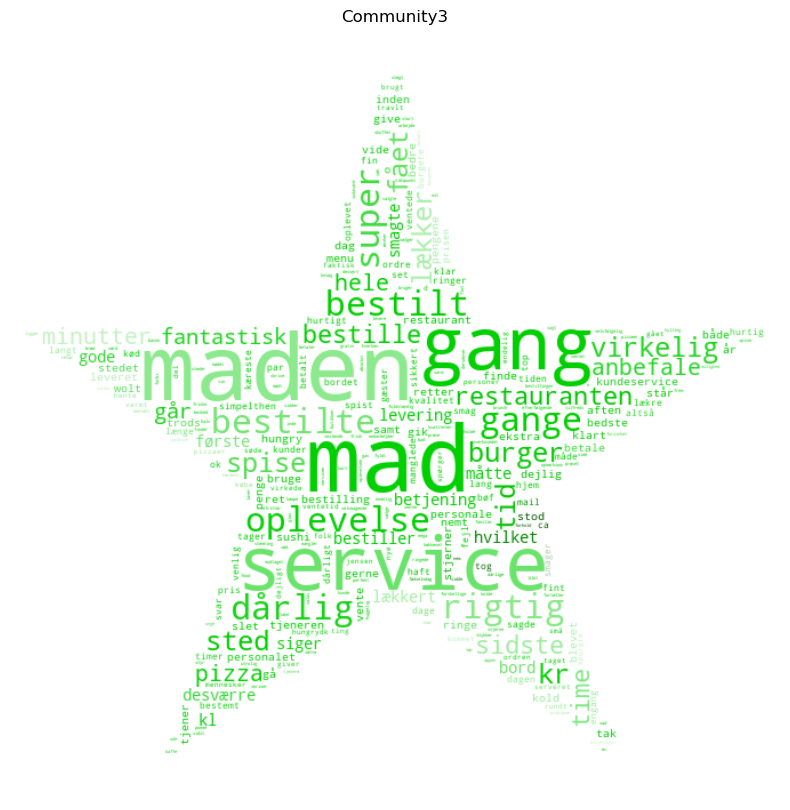

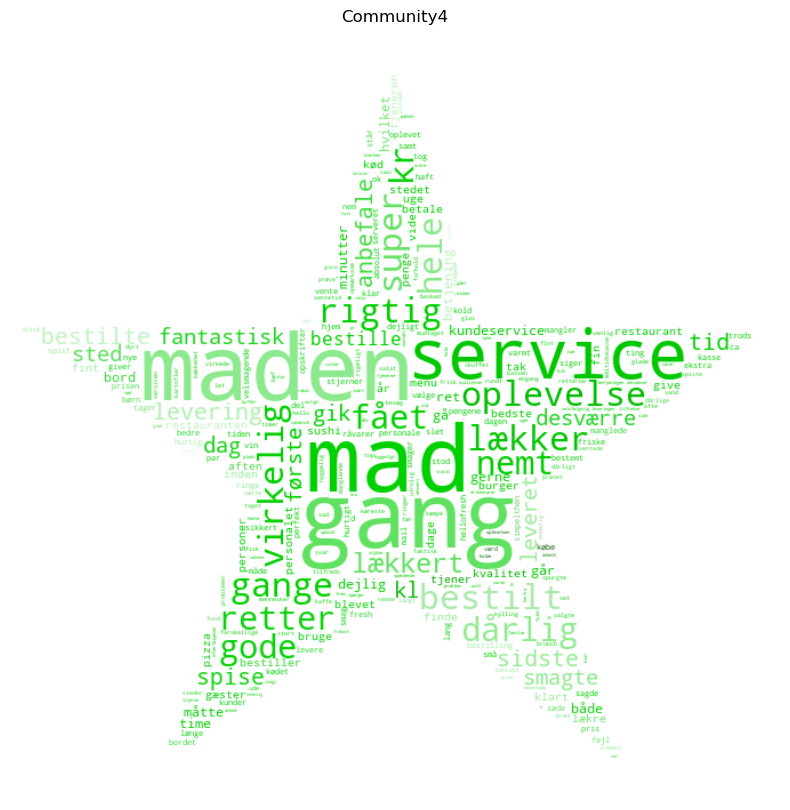

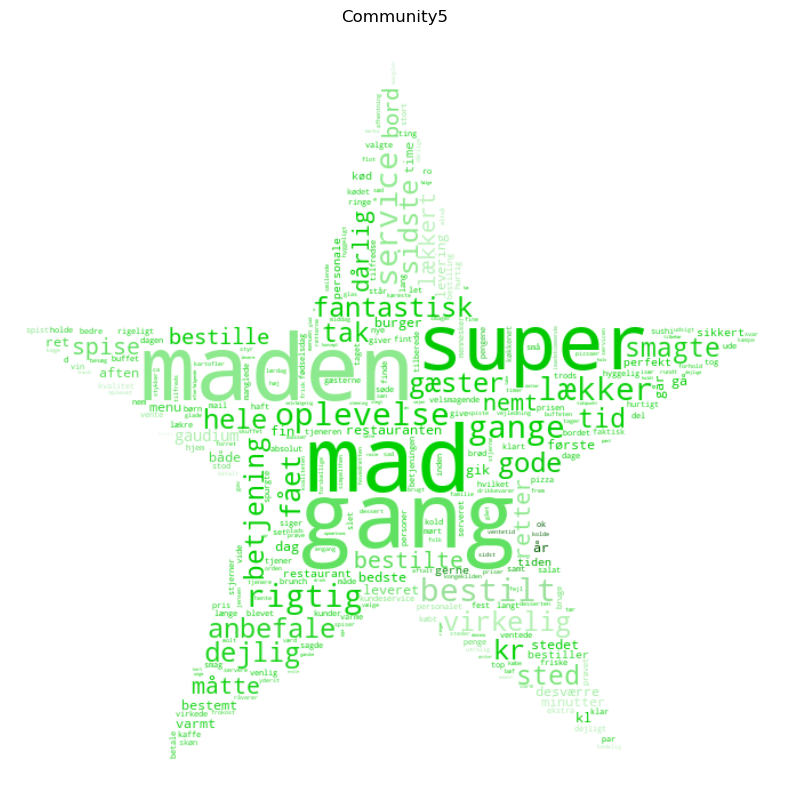

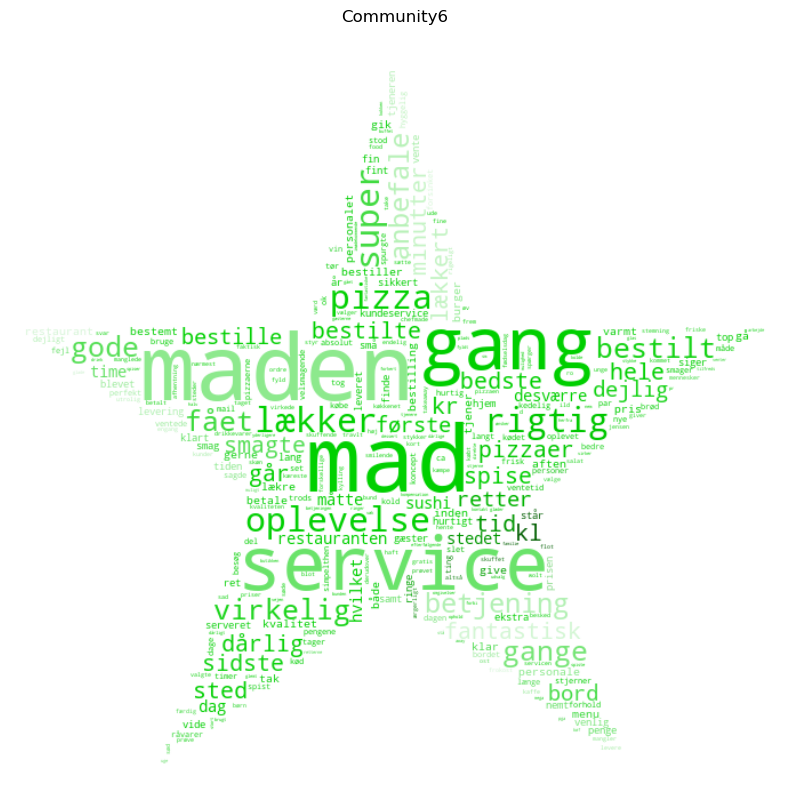

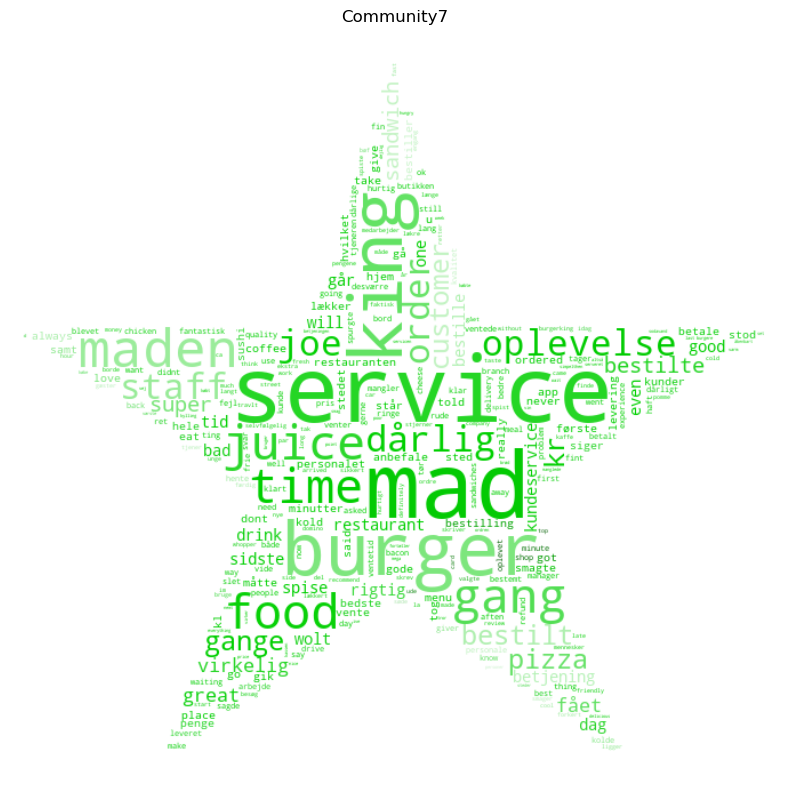

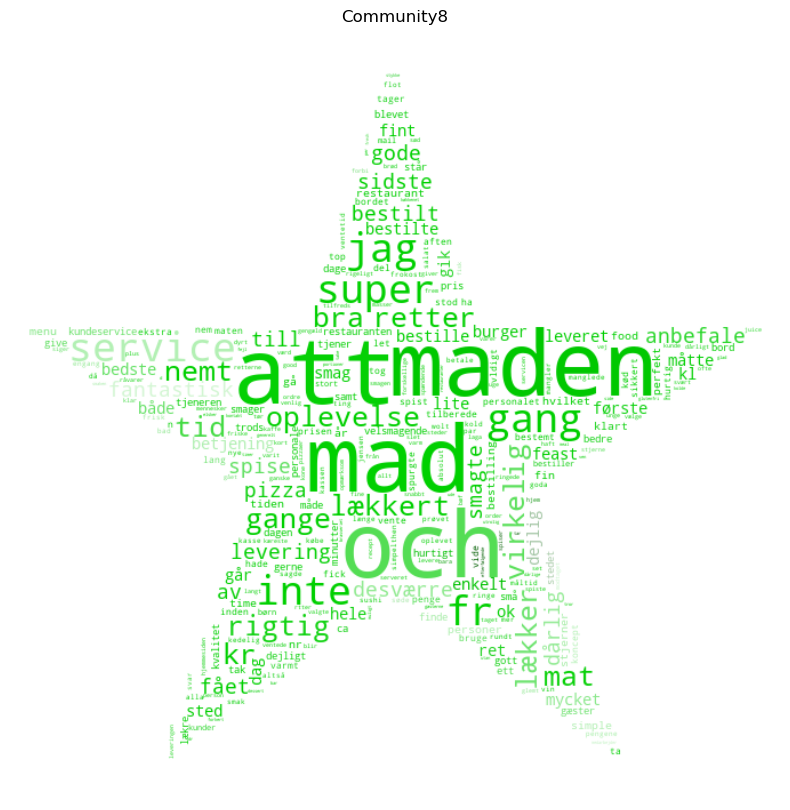

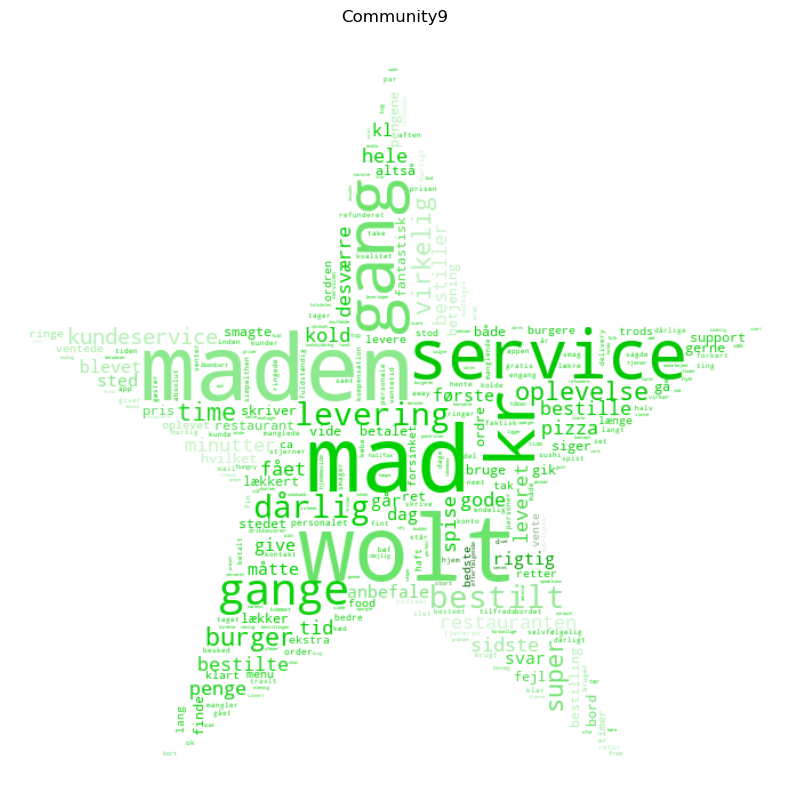

In [33]:
# Drawing
for i, t in enumerate(text):
    plt.figure(figsize=(10, 10))
    # create word cloud
    wc = WordCloud(
        max_words=300, 
        mask=mask, 
        max_font_size=80, 
        random_state=1337, 
        relative_scaling=0, 
        collocations=False,
        background_color ='white'
    )
    # add text
    wc.generate(t)
    
    # add colors
    image_colors = ImageColorGenerator(color)
    wc.recolor(color_func=image_colors)
    
    # plot options
    title = "Community"+str(i)
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('wordcloud//wordcloud_community_'+str(i)+'.png', bbox_inches='tight')
    plt.show()

In [34]:
# business in specific communities
for com in G_community[8]: # Change 8 to whatever commmunity you want
    if com in set0:
        print(com)

simplefeast.com
boffburgerbar.dk
www.roomservice.dk
bjoernekaelderen.dk
bubliq.com
www.thai4you.dk
www.chinaasiahouse.dk
cafedepicasso.dk
cafedivino.dk
www.kastrupstrandpark.dk
www.brasseriet-gilleleje.dk
cafekirkeladen.dk
cafepiaf.dk
jatakspisehus.dk
pizzabarbaros.dk
chefe.dk
www.sukaiba.dk
www.villavest.dk
www.thaipan.dk
southindian.dk
hotel-saxkjobing.dk
denhvideelefant.dk
detsimrer.dk
donjuan.dk
www.makisushi.dk
www.italia-holstebro.dk
jaegerhuset.dk
restaurantvita.dk
foody.dk
www.noma.dk
thevietnamese.dk
www.lieffroy.dk
hansenscatering.dk
nembuffet.dk
hav2go.dk
www.krebshuset.dk
rawbite.com
lacoruna.dk
lemenu.dk
www.copenhagencatering.dk
myntethaicuisine.dk
netto.se
nielsogsinnesfiskerestaurant.dk
peoplelikeus.dk
re-union.dk
www.strandkroen-ebeltoft.dk
scurryhub.dk
sukisushi.dk
whip-gas.se
www.pizzarosaranders.dk


## Calculate avg ratings ('reviews')

In [35]:
# Find average rating of business
avgRatingList1 = {}

for business in businessNames:
    ratings = []
    for user in reviews[business]:
        ratings.append(int(user['rating']))
    print(business, end="\r")
    avgRatingList1[business]=(sum(ratings)/len(ratings))

## Calculate avg ratings ('userDk')

In [36]:
# Find average rating of business
avgRatingList2 = {}

for business in businessNamesExpanded:
    ratings = []
    for user in reviewsExpanded[business]:
        userId = list(user.keys())[0]
        reviewer = user[userId]
        for review in reviewer:
            ratings.append(int(review['trustScore']))
    print(business, end="\r")
    avgRatingList2[business]=(sum(ratings)/len(ratings))

## Analyse network

In [37]:
#max(degree_sequence2) # Have to be run after below code...

## Degree distribution for restaurants and bars

In [38]:
restaurant_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
user_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
other_categories_nodes = set(G) - restaurant_nodes - user_nodes

degree_sequence1 = []
degree_sequence2 = []
degree_sequence3 = []

for node in restaurant_nodes:
    degree_sequence1.append(G.degree(node))
for node in user_nodes:
    degree_sequence2.append(G.degree(node))
for node in other_categories_nodes:
    degree_sequence3.append(G.degree(node))
    
degree_sequence1.sort()
degree_sequence1.reverse()
degree_sequence2.sort()
degree_sequence2.reverse()
degree_sequence3.sort()
degree_sequence3.reverse()

In [39]:
def findPowerLawSlope(degrees):
    # binning vector
    v = []
    for i in range(max(degrees) - min(degrees) + 1):
        v.append(min(degrees) + i)

    # degree distribution
    hist, bin_edges = np.histogram(degrees, bins=v)

    newHist = []
    newBin = []
    count = 1
    for h in hist:
        if h>0:
            newHist.append(h)
            newBin.append(count)
        count += 1

    # Using numpy to find slope
    slope, intercept = np.polyfit(np.log(newBin), np.log(newHist), 1)

    return slope, intercept

In [40]:
max(degree_sequence1)
len(degree_sequence1)

1413

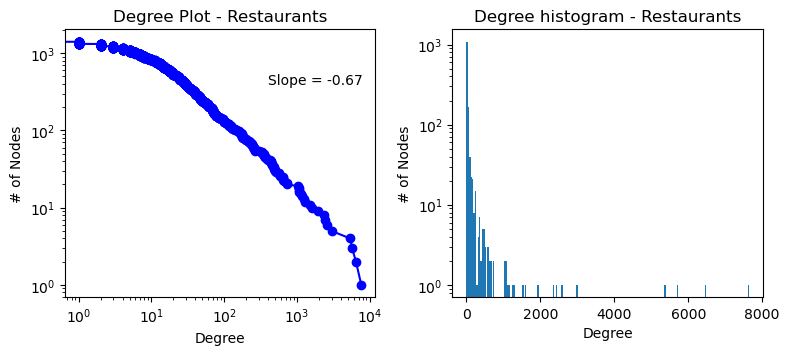

Slope of Degree Rank Plot (-0.6685427779039165, 4.133257732400531)


In [41]:
fig1 = plt.figure("Degree plot restaurants", figsize=(8, 8))
axgrid1 = fig1.add_gridspec(5, 4)

ax1 = fig1.add_subplot(axgrid1[3:, :2])
ax1.loglog(degree_sequence1,list(range(1, len(degree_sequence1) + 1)), "b-", marker="o")
ax1.plot()
#plt.yscale("log") 
ax1.set_title("Degree Plot - Restaurants")
ax1.set_ylabel("# of Nodes")
ax1.set_xlabel("Degree")
plt.text(400, 400, 'Slope = -0.67')

ax2 = fig1.add_subplot(axgrid1[3:, 2:])
ax2.hist(degree_sequence1, len([*set(degree_sequence1)]))
ax2.set_title("Degree histogram - Restaurants")
# plt.xscale("log")
plt.yscale("log")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")
fig1.tight_layout()
plt.show()
print("Slope of Degree Rank Plot",findPowerLawSlope(degree_sequence1))

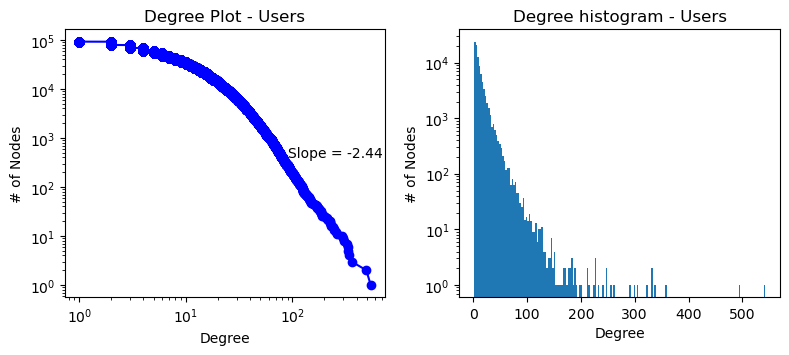

Slope of Degree Rank Plot (-2.4376736838698894, 13.360019331581515)


In [42]:
fig2 = plt.figure("Degree plot users", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid2 = fig2.add_gridspec(5, 4)

ax3 = fig2.add_subplot(axgrid2[3:, :2])
ax3.loglog(degree_sequence2,list(range(1, len(degree_sequence2) + 1)), "b-", marker="o")
#plt.yscale("log") 
ax3.set_title("Degree Plot - Users")
ax3.set_ylabel("# of Nodes")
ax3.set_xlabel("Degree")
plt.text(90, 400, 'Slope = -2.44')

ax4 = fig2.add_subplot(axgrid2[3:, 2:])
ax4.hist(degree_sequence2, len([*set(degree_sequence2)]))
ax4.set_title("Degree histogram - Users")
plt.yscale("log") 
ax4.set_xlabel("Degree")
ax4.set_ylabel("# of Nodes")
fig2.tight_layout()
plt.show()
print("Slope of Degree Rank Plot",findPowerLawSlope(degree_sequence2))

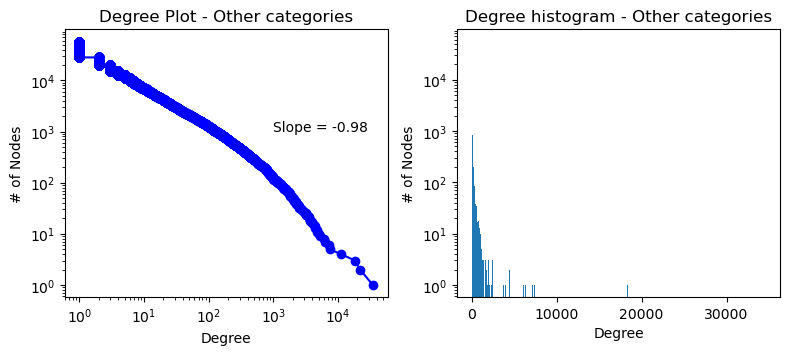

Slope of Degree Rank Plot (-0.977717548249333, 6.714656136635771)


In [43]:
fig3 = plt.figure("Degree plot other categories", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid3 = fig3.add_gridspec(5, 4)

ax5 = fig3.add_subplot(axgrid3[3:, :2])
ax5.loglog(degree_sequence3,list(range(1, len(degree_sequence3) + 1)), "b-", marker="o")
#plt.yscale("log") 
ax5.set_title("Degree Plot - Other categories")
ax5.set_ylabel("# of Nodes")
ax5.set_xlabel("Degree")
plt.text(1000, 1000, 'Slope = -0.98')

ax6 = fig3.add_subplot(axgrid3[3:, 2:])
ax6.hist(degree_sequence3, len([*set(degree_sequence3)]))
ax6.set_title("Degree histogram - Other categories")
plt.yscale("log") 
ax6.set_xlabel("Degree")
ax6.set_ylabel("# of Nodes")
fig3.tight_layout()
plt.show()
print("Slope of Degree Rank Plot",findPowerLawSlope(degree_sequence3))

# Sentiment Analysis

## Functions

In [44]:
words = pd.read_csv('words.txt', sep="\t")
lexicon = pd.read_csv('lexicon.csv', sep=",")

happiness_words = list(words[words.keys()[0]])
happiness_average = list(words[words.keys()[2]])
happiness_words_dk = list(lexicon['word'])
happiness_average_dk = list(lexicon['score'])

def sentimentByFreq(tokens, freq):
    # Checks how happy a set of tokens are based on most_common
    counter = 0
    total = 0
    tokenIndex = []
    happinessIndex = []
    for i in range(len(tokens)):
        if tokens[i] in happiness_words:
            tokenIndex.append(i)
            happinessIndex.append(happiness_words.index(tokens[i]))
    for i in range(len(tokenIndex)):
        counter += happiness_average[happinessIndex[i]] * freq[tokenIndex[i]]
        total += freq[tokenIndex[i]]
    if total == 0:
        counter = None
    else:
        counter /= total
    return counter

def sentimentByFreqDk(tokens, freq):
    # Checks how happy a set of tokens are based on most_common
    counter = 0
    total = 0
    tokenIndex = []
    happinessIndex = []
    for i in range(len(tokens)):
        if tokens[i] in happiness_words_dk:
            tokenIndex.append(i)
            happinessIndex.append(happiness_words_dk.index(tokens[i]))
    for i in range(len(tokenIndex)):
        counter += happiness_average_dk[happinessIndex[i]] * freq[tokenIndex[i]]
        total += freq[tokenIndex[i]]
    if total == 0:
        counter = None
    else:
        counter /= total
    return counter

## Get businesses with more than 20 reviews

In [45]:
# Folder containing reviews
categoriesFolder = os.listdir('categories')

# Get usersDk from folder
f = open('categories/restaurants_barsDK.json')
categories = json.load(f)

businessAbv20 = []
for business in categories:
    if business['numberOfReviews'] >= 20:
        businessAbv20.append(business['identifyingName'])
        
businessCph = []
for business in categories:
    name = business['location']['city']
    if business['numberOfReviews'] >= 20:
        if name == 'Copenhagen' or name == 'K\u00f8benhavn SV' or name == 'Copenhagen C' or name == 'K\u00f8benhavn K' or name == 'K\u00f8benhavn' or name == 'K\u00f8benhavn N' or name == 'K\u00f8benhavn NV' or name == 'Frederiksberg':
            businessCph.append(business['identifyingName'])
    

## Tokenize reviews and find most common words

In [46]:
import nltk
from nltk import *

# For businesses with more than 20 reviews

fdistList = []
commonList = []

count1 = 1
for business in businessAbv20:
    reviewList = ""
    count2 = 0
    for user in reviews[business]:
        reviewList += user['review'] + " "
        count2 += 1
    
    print(count1, "/", len(businessAbv20), ":", count2, ":", business, end="\r")
    
    # Tokenize lists
    token = reviewList.split()

    fdistList += [FreqDist(token)]
    commonList += [fdistList[-1].most_common()]
    count1 += 1

In [47]:
# For businesses in Copenhagen

fdistListCph = []
commonListCph = []

count1 = 1
for business in businessCph:
    reviewList = ""
    count2 = 0
    for user in reviews[business]:
        reviewList += user['review'] + " "
        count2 += 1
    
    print(count1, "/", len(businessCph), ":", count2, ":", business, end="\r")
    
    # Tokenize lists
    token = reviewList.split()

    fdistListCph += [FreqDist(token)]
    commonListCph += [fdistListCph[-1].most_common()]
    count1 += 1

## Convert list of most common into word- and frequency list

In [48]:
wordList = []
freqList = []

for i in range(len(commonList)):
    tempList1 = []
    tempList2 = []
    for n in range(len(commonList[i])):
        tempList1.append(commonList[i][n][0])
        tempList2.append(commonList[i][n][1])
    wordList.append(tempList1)
    freqList.append(tempList2)

In [49]:
wordListCph = []
freqListCph = []

for i in range(len(commonListCph)):
    tempList1 = []
    tempList2 = []
    for n in range(len(commonListCph[i])):
        tempList1.append(commonListCph[i][n][0])
        tempList2.append(commonListCph[i][n][1])
    wordListCph.append(tempList1)
    freqListCph.append(tempList2)

## For every business, find their average sentiment

In [50]:
sentimentList = []
for i in range(len(freqList)):
    sentimentList.append(sentimentByFreq(wordList[i], freqList[i]) + sentimentByFreqDk(wordList[i], freqList[i]))
    print(i+1, '/', len(freqList), ":", businessAbv20[i], end="\r")

In [51]:
sentimentListCph = []
for i in range(len(freqListCph)):
    sentimentListCph.append(sentimentByFreq(wordListCph[i], freqListCph[i]) + sentimentByFreqDk(wordListCph[i], freqListCph[i]))
    print(i, '/', len(freqListCph), ":", businessCph[i], end="\r")

In [52]:
print('avg sentiment Cph :', sum(sentimentListCph)/len(sentimentListCph))

avg sentiment Cph : 5.762089271878887


## Attach average sentiment to business through json

In [53]:
sentimentJson = {}
for i in range(len(sentimentList)):
    sentimentJson[businessAbv20[i]] = sentimentList[i]
    print(i, '/', len(freqList), end="\r")

In [54]:
sentimentJsonCph = {}
for i in range(len(sentimentListCph)):
    sentimentJsonCph[businessCph[i]] = sentimentListCph[i]
    print(i, '/', len(freqListCph), end="\r")

## Function used to find multiple indicies

In [55]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

## Find 10 highest/lowest rated businesses from avgUserRating and trustScore

In [56]:
ratingList = []
for business in businessAbv20:
    ratingList.append(avgRatingList2[business])

indexRatingList = []
for i in sorted(ratingList):
    if find_indices(ratingList, i) not in indexRatingList:
        indexRatingList.append(find_indices(ratingList, i))

indexRatingList = list(chain.from_iterable(indexRatingList))

print('Highest TrustScores from users \n')
print('Rank|AvgRating|trustScore|Name')
print('--------------------------------')
for x in range(10):
    print('Nr', x+1, "&", '{:.3}'.format(avgRatingList2[businessAbv20[indexRatingList[-x-1]]]), "&", categories[indexRatingList[-x-1]]['trustScore'], "&", businessAbv20[indexRatingList[-x-1]])
print('\n')
print('Lowest TrustScores from users \n')
print('Rank|AvgRating|trustScore|Name')
print('--------------------------------')
for x in range(10):
    print('Nr', x+1, "&", '{:.3}'.format(avgRatingList2[businessAbv20[indexRatingList[x]]]), "&", categories[indexRatingList[x]]['trustScore'], "&", businessAbv20[indexRatingList[x]])

Highest TrustScores from users 

Rank|AvgRating|trustScore|Name
--------------------------------
Nr 1 & 4.76 & 4.3 & whip-gas.se
Nr 2 & 4.72 & 4.8 & koldingkokken.dk
Nr 3 & 4.72 & 4.8 & rolfstedselskabslokaler.dk
Nr 4 & 4.7 & 4.3 & bubliq.com
Nr 5 & 4.69 & 4.5 & shop.glutenfrimagi.dk
Nr 6 & 4.69 & 4.8 & www.buffetbussen.dk
Nr 7 & 4.68 & 4.9 & startpackage-malaga.com
Nr 8 & 4.67 & 4.8 & roegeri.dk
Nr 9 & 4.65 & 4 & oc-co.dk
Nr 10 & 4.64 & 4.9 & nordfra.com


Lowest TrustScores from users 

Rank|AvgRating|trustScore|Name
--------------------------------
Nr 1 & 2.43 & 2.8 & www.scocykler.dk
Nr 2 & 2.82 & 2.2 & ravage.dk
Nr 3 & 2.99 & 1.5 & www.carlsberg.dk
Nr 4 & 3.03 & 2.6 & rest-bellini.dk
Nr 5 & 3.03 & 1.7 & www.oliolipoke.com
Nr 6 & 3.05 & 2.3 & bigben-pizza.dk
Nr 7 & 3.07 & 2.4 & marmariskebab.dk
Nr 8 & 3.12 & 3.9 & www.masamisushi.dk
Nr 9 & 3.13 & 1.7 & mrpizza.dk
Nr 10 & 3.13 & 3.3 & greatsushi.dk


## Find 10 highest/lowest sentiments

In [57]:
indexList = []
for i in sorted(sentimentList):
    indexList.append(sentimentList.index(i))
    
print('Highest Sentiments \n')
print('Rank | Sentiment | Name')
print('--------------------------------')
for x in range(10):
    print('Nr', x+1, "&", '{:.3}'.format(sentimentJson[businessAbv20[indexList[-x-1]]]), "&", businessAbv20[indexRatingList[-x-1]])

print('\n')
print('Lowest Sentiments \n')
print('Rank | Sentiment | Name')
print('--------------------------------')
for x in range(10):
    print('Nr', x+1, "&", '{:.3}'.format(sentimentJson[businessAbv20[indexList[x]]]), "&", businessAbv20[indexRatingList[x]])

Highest Sentiments 

Rank | Sentiment | Name
--------------------------------
Nr 1 & 7.07 & whip-gas.se
Nr 2 & 7.04 & koldingkokken.dk
Nr 3 & 6.99 & rolfstedselskabslokaler.dk
Nr 4 & 6.98 & bubliq.com
Nr 5 & 6.98 & shop.glutenfrimagi.dk
Nr 6 & 6.93 & www.buffetbussen.dk
Nr 7 & 6.9 & startpackage-malaga.com
Nr 8 & 6.89 & roegeri.dk
Nr 9 & 6.85 & oc-co.dk
Nr 10 & 6.84 & nordfra.com


Lowest Sentiments 

Rank | Sentiment | Name
--------------------------------
Nr 1 & 4.58 & www.scocykler.dk
Nr 2 & 4.6 & ravage.dk
Nr 3 & 4.6 & www.carlsberg.dk
Nr 4 & 4.63 & rest-bellini.dk
Nr 5 & 4.64 & www.oliolipoke.com
Nr 6 & 4.65 & bigben-pizza.dk
Nr 7 & 4.66 & marmariskebab.dk
Nr 8 & 4.66 & www.masamisushi.dk
Nr 9 & 4.67 & mrpizza.dk
Nr 10 & 4.7 & greatsushi.dk


## Determine correlation between sentiment and trustScore

In [58]:
# Make array of trustScores
trustScoreList = []
avgRatingArray = []

for count in range(len(businessAbv20)):
    trustScoreList.append(categories[count]['trustScore'])

for count in range(len(businessAbv20)):
    avgRatingArray.append(avgRatingList2[businessAbv20[count]])

In [59]:
# Correlation between sentiment and trustScore
print('correlation between : trustScore & sentiment :', np.corrcoef(trustScoreList, sentimentList)[0][1])
print('correlation between : trustScore & user rating :', np.corrcoef(trustScoreList, avgRatingArray)[0][1])
print('correlation between : sentiment & user rating :', np.corrcoef(sentimentList, avgRatingArray)[0][1])

correlation between : trustScore & sentiment : 0.8268081338041563
correlation between : trustScore & user rating : 0.6169360067133979
correlation between : sentiment & user rating : 0.6578698134387037


## SENTIMENT - Plot the histogram and display mean, median, 10th and 90th percentile

In [60]:
hist, bin_edges = np.histogram(sentimentList, bins = 20)
print('Hist:', hist, '\n')
print('Bin edges:', bin_edges)

Hist: [ 9 10 22 30 41 39 66 54 53 67 41 40 33 30 29 24 22  9  5  5] 

Bin edges: [4.57939942 4.70386304 4.82832666 4.95279028 5.07725391 5.20171753
 5.32618115 5.45064478 5.5751084  5.69957202 5.82403565 5.94849927
 6.07296289 6.19742651 6.32189014 6.44635376 6.57081738 6.69528101
 6.81974463 6.94420825 7.06867187]


In [61]:
def mean(dataset):
    return sum(dataset) / len(dataset)

def median(dataset):
    dataset = sorted(dataset)
    if (len(dataset) % 2 == 0):
        return (dataset[int(len(dataset) / 2)] + dataset[int(len(dataset) / 2 - 1)]) / 2
    else:
        return dataset[int((len(dataset) - 1) / 2)]

# 10th Percentile
print('10th percentile', np.percentile(sentimentList, 10), '\n')

# 90th Percentile
print('90th percentile', np.percentile(sentimentList, 90), '\n')

# mean
print('mean', mean(sentimentList), '\n')

# Median
print('median', median(sentimentList), '\n')

10th percentile 5.038142311656976 

90th percentile 6.457317827356248 

mean 5.707928960672861 

median 5.668029076866288 



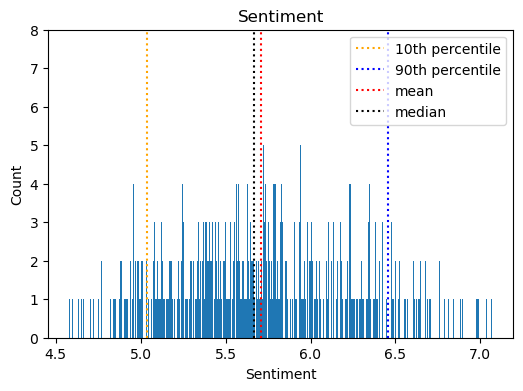

In [70]:
#plt.plot(bin_edges[:-1],hist)
plt.figure(figsize=(6, 4))
plt.hist(sentimentList, len([*set(sentimentList)]))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment')
plt.vlines(x = np.percentile(sentimentList, 10), ymin = 0, ymax = max(hist), 
           colors = 'orange', 
           linestyle='dotted',
           label = '10th percentile')
plt.vlines(x = np.percentile(sentimentList, 90), ymin = 0, ymax = max(hist), 
           colors = 'blue', 
           linestyle='dotted',
           label = '90th percentile')
plt.vlines(x = mean(sentimentList), ymin = 0, ymax = max(hist), 
           colors = 'red', 
           linestyle='dotted',
           label = 'mean')
plt.vlines(x = median(sentimentList), ymin = 0, ymax = max(hist), 
           colors = 'black', 
           linestyle='dotted',
           label = 'median')
plt.ylim([0, 8])
plt.legend()
plt.show()

## Label permutation test

In [71]:
# Label permutation test of businesses in Cph
counter = 0
avgSentiment = sum(sentimentListCph)/len(sentimentListCph)
sentiment_rand = 0
epoc = 10000

for n in range(epoc):
    rBusiness = numpy.random.permutation(len(businessAbv20))[0:len(businessCph)]
    for i in range(len(businessCph)):
        sentiment_rand += sentimentList[rBusiness[i]]
    sentiment_rand /= len(businessCph)
    if sentiment_rand > avgSentiment:
        counter += 1
counter = counter / epoc * 100
print('percent of time H1 is true:', counter, '%')

percent of time H1 is true: 77.62 %
